In [1]:
import numpy as np
import h5py
from tqdm import trange
import pandas as pd
import seaborn as sn
import sys
import itertools
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime

/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib

In [2]:
def plot_confusion_matrix_mc(Y_true, Y_pred,
                             target_names,
                             name_file_output,
                             title='Confusion matrix',
                             cmap=None,
                             normalize=True):
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(name_file_output, format='pdf')
    plt.show()


In [3]:
class WaveNetClassifier():
  def __init__(self, input_shape, output_shape, kernel_size = 2, dilation_depth = 9, n_filters = 40, task = 'classification', regression_range = None, load=False, load_dir='./'):
    """
    Parameters:
      input_shape: (tuple) tuple of input shape. (e.g. If input is 6s raw waveform with sampling rate = 16kHz, (96000,) is the input_shape)
      output_shape: (tuple)tuple of output shape. (e.g. If we want classify the signal into 100 classes, (100,) is the output_shape)
      kernel_size: (integer) kernel size of convolution operations in residual blocks
      dilation_depth: (integer) type total depth of residual blocks
      n_filters: (integer) # of filters of convolution operations in residual blocks
      task: (string) 'classification' or 'regression'
      regression_range: (list or tuple) target range of regression task
      load: (bool) load previous WaveNetClassifier or not
      load_dir: (string) the directory where the previous model exists
    """      
    # save task info
    self.task=task
    if task == 'regression':
      if regression_range[0] == 0:
        self.activation = 'sigmoid'
        self.scale_ratio = regression_range[1]
      elif regression_range[0] == - regression_range[1]:
        self.activation = 'tanh'
        self.scale_ratio = regression_range[1]
      elif regression_range == None:
        self.activation = 'linear'
        self.scale_ratio = 1
      else:
        print('ERROR: wrong regression range')
        sys.exit()  
    elif task == 'classification':
      self.activation = 'softmax'
      self.scale_ratio = 1      
    else:
      print('ERROR: wrong task')
      sys.exit()
    
    # save input info
    if len(input_shape) == 1:
      self.expand_dims = True
    elif len(input_shape) == 2:
      self.expand_dims = False
    else:
      print('ERROR: wrong input shape')
      sys.exit()
    self.input_shape = input_shape
    
    # save output info
    if len(output_shape) == 1:
      self.time_distributed = False
    elif len(output_shape) == 2:
      self.time_distributed = True
    else:
      print('ERROR: wrong output shape')
      sys.exit()
    self.output_shape = output_shape
    
    # save hyperparameters of WaveNet
    self.kernel_size = kernel_size
    self.dilation_depth = dilation_depth
    self.n_filters = n_filters
    self.manual_loss = None

    
    if load is True:
      self.model = load_model(load_dir+"saved_wavenet_clasifier.h5", custom_objects={'tf':tf})
      self.prev_history = pd.read_csv(load_dir+'wavenet_classifier_training_history.csv')
      self.start_idx = len(self.prev_history)
      self.history = None
    else:
      self.model = self.construct_model()
      self.start_idx = 0
      self.history = None
      self.prev_history = None

    
  def residual_block(self, x, i):
    tanh_out = Conv1D(self.n_filters, 
                      self.kernel_size, 
                      dilation_rate = self.kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (self.kernel_size ** i), 
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(self.n_filters, 
                      self.kernel_size, 
                      dilation_rate = self.kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (self.kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(self.n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip
  
  def construct_model(self):   
    x = Input(shape=self.input_shape, name='original_input')
    
    self.expand_dims = True
    if self.expand_dims == True:
      #in_dim = [self.input_shape[0], self.input_shape[1]]     
      #x_reshaped = Reshape(in_dim + [1], input_shape = in_dim, name='reshaped_input')(x)
      x_reshaped = Reshape(self.input_shape + (1,), name='reshaped_input')(x)
    else:
      x_reshaped = x
    skip_connections = []
    
    conv2d = Conv2D(self.n_filters, 2, strides=2, padding='same',  name='conv2d')(x_reshaped)
    
    out= Reshape((conv2d.shape[2].value,conv2d.shape[3].value), name='conv2d_to_1d')(conv2d)
    
    out = Conv1D(self.n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(out)
    #out = Conv1D(self.n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x_reshaped)
    for i in range(1, self.dilation_depth + 1):
      out, skip = self.residual_block(out,i)
      skip_connections.append(skip)
    out = Add(name='skip_connections')(skip_connections)
    out = Activation('relu')(out)
    out = Conv1D(self.n_filters, 80, strides = 1, padding='causal', name='conv_5ms', activation = 'relu')(out)
    out = AveragePooling1D(80, padding='same', name='downsample_to_200Hz')(out)
    if self.time_distributed:
      target_kernel_size = (int) (self.input_shape[0] / 80 / self.output_shape[0]) # prev_len / x = target_len => x = prev_len / target_len
      out = Conv1D(self.n_filters, target_kernel_size, padding='causal', name = 'conv_fit_to_target', activation='relu')(out)
      out = Conv1D(self.output_shape[1], target_kernel_size, padding='causal', name='conv_final')(out)
      out = AveragePooling1D(target_kernel_size, padding='same')(out)
      out = TimeDistributed(Activation(self.activation))(out)
    else:
      out = Conv1D(self.n_filters, 100, padding='causal', activation='relu', name='conv_500ms')(out)
      out = Conv1D(self.output_shape[0], 100, padding='causal', activation='relu', name='conv_500ms_target_shape')(out)
      out = AveragePooling1D(100, padding='same',name = 'downsample_to_2Hz')(out)
      out = Conv1D(self.output_shape[0], (int) (self.input_shape[1] / 8000), padding='same', name='final_conv')(out)
      out = AveragePooling1D((int) (self.input_shape[1] / 8000), name='final_pooling')(out)
      out = Flatten()(out)
      out = Dense(3, activation = 'softmax' )(out)
      #out = Reshape(self.output_shape)(out)
      #out = Activation(self.activation)(out)
    if self.scale_ratio != 1:
      out = Lambda(lambda x: x * self.scale_ratio, name='output_reshaped')(out)
    model = Model(x, out)  
    model.summary()
    return model
    
  def get_model(self):
    return self.model
    
  def add_loss(self, loss):
    self.manual_loss = loss
  
  def fit(self, X, Y, validation_data = None, epochs = 100, batch_size = 16, optimizer='adam', save=False, save_dir='./'):
    # set default losses if not defined
    if self.manual_loss is not None:
      loss = self.manual_loss
      metrics = None
    else:
      if self.task == 'classification':
        loss = 'categorical_crossentropy'
        metrics = ['accuracy']
      else:
        loss = 'mean_squared_error'
        metrics = None
        
    # set callback functions
    if save:
      # datetime object containing current date and time
      time_model = now = datetime.now()
      dt_string = now.strftime("%d%m%Y%H%M%S")
      saved = save_dir + dt_string+"_saved_wavenet_clasifier.h5"
      hist = save_dir + dt_string+"_wavenet_classifier_training_history.csv"
      if validation_data is None:
        checkpointer = ModelCheckpoint(filepath=saved, monitor='loss', verbose=1, save_best_only=True)
      else:
        checkpointer = ModelCheckpoint(filepath=saved, monitor='val_loss', verbose=1, save_best_only=True)
      history = History()
      early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 0, mode = 'auto')
      callbacks = [history, checkpointer, early_stop]
      #callbacks = [history, checkpointer]
    else:
      callbacks = None
      
    # compile the model
    self.model.compile(optimizer, loss, metrics)
    try:
      self.history = self.model.fit(X, Y, shuffle = True, validation_split=0.2, batch_size=batch_size, epochs = epochs, validation_data = validation_data, callbacks=callbacks, initial_epoch=self.start_idx)
    except:
      if save:
      	df = pd.DataFrame.from_dict(history.history)
      	df.to_csv(hist, encoding='utf-8', index=False)
      raise
      sys.exit()
    return self.history


  def predict(self, x):
    return self.model.predict(x)

In [4]:
def get_raw_xy(dataset_folder,dataset_filename):
    path_to_dataset = dataset_folder+dataset_filename
    f = h5py.File(path_to_dataset,'r')
    X_obj = f['X']
    Y_obj = f['Y']
    [r,c] = f['X'].shape
    X = []
    Y = []
    for i in trange(r):
        X.append(np.array(f[X_obj[i][0]], dtype=np.int16))
        Y.append(np.array(f[Y_obj[i][0]], dtype=np.int8))
      #X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=num_iq_seq, padding=padding, truncating=padding)

    return X,Y

In [5]:
def pad_or_trunc_x(X, num_iq_seq, padding):
    X_padded = []
    num_samples=len(X)
    for i in trange(num_samples):
        X_padded.append(pad_sequences(X[i], maxlen=num_iq_seq, padding=padding, truncating=padding))
    return np.array(X_padded)
    

In [6]:
def get_one_shot_labels(Y, num_classes):
    Y_cat = to_categorical(Y,num_classes=num_classes)
    return(Y_cat.reshape((Y_cat.shape[0],Y_cat.shape[2])))
    

In [7]:
def get_xy_4_training(X,Y,seed):
    X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=seed)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [8]:
seed = 42
num_classes = 3
num_iq_seq = 10000# 2.5ms at 20MHz BW
padding = 'post'

In [9]:
dataset_folder = '../new_dataset/waveforms/'
dataset_filename = 'waveforms_2G_n_multi_mobile_app_multi_channel_100k_balanced.mat'

In [10]:
#X,Y = get_xy(dataset_folder,dataset_filename, num_classes, num_iq_seq, padding)

In [11]:
Xraw, Yraw = get_raw_xy(dataset_folder,dataset_filename)

100%|██████████| 57408/57408 [01:06<00:00, 861.68it/s] 


In [12]:
X = pad_or_trunc_x(Xraw, num_iq_seq, padding)
Y = get_one_shot_labels(Yraw, num_classes)

100%|██████████| 57408/57408 [00:04<00:00, 13115.61it/s]


In [13]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = get_xy_4_training(X,Y,seed)
print(X_train.shape,X_val.shape, X_test.shape)
print(Y_train.shape,Y_val.shape, Y_test.shape)

(40185, 2, 10000) (8611, 2, 10000) (8612, 2, 10000)
(40185, 3) (8611, 3) (8612, 3)


In [14]:
dataset_filename_qos = 'waveforms_2G_n_multi_mobile_app_2_only_qos.mat'
#X_qos, Y_qos = get_xy(dataset_folder,dataset_filename_qos, num_classes, num_iq_seq, padding)

In [15]:
Xraw_qos, Yraw_qos = get_raw_xy(dataset_folder,dataset_filename_qos)

100%|██████████| 13765/13765 [00:16<00:00, 827.08it/s]


In [16]:
X_qos = pad_or_trunc_x(Xraw_qos, num_iq_seq, padding)
Y_qos = get_one_shot_labels(Yraw_qos, num_classes)

100%|██████████| 13765/13765 [00:01<00:00, 9018.57it/s]


In [17]:
print(X_qos.shape, Y_qos.shape)

(13765, 2, 10000) (13765, 3)


In [18]:
dataset_filename_test2 = 'waveforms_2G_n_multi_mobile_app_multi_channel_21042020_balanced.mat'

In [19]:
Xraw_test2, Yraw_test2 = get_raw_xy(dataset_folder,dataset_filename_test2)

100%|██████████| 155839/155839 [07:03<00:00, 368.29it/s] 


In [20]:
X_test2 = pad_or_trunc_x(Xraw_test2, num_iq_seq, padding)
Y_test2 = get_one_shot_labels(Yraw_test2, num_classes)

100%|██████████| 155839/155839 [20:47<00:00, 124.91it/s]


In [21]:
print(X_test2.shape, Y_test2.shape)

(155839, 2, 10000) (155839, 3)


In [22]:
wnc = WaveNetClassifier((2,num_iq_seq), (num_classes,), kernel_size = 2, dilation_depth = 6, n_filters = 32)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 2, 10000)     0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 2, 10000, 1)  0           original_input[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 5000, 32)  160         reshaped_input[0][0]             
__________________________________________________________________________________________________
conv2d_to_1d (Reshape)          (None, 5000, 32)     0           conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
wnc.fit(X_train, Y_train, validation_data = (X_val, Y_val),save=True, epochs = 50)

In [27]:
wcn_model = wnc.get_model()

In [28]:
test_results = wcn_model.evaluate(X_test, Y_test)
print(test_results)

8612/8612 [==============================] - 32s 4ms/step
[0.006472596552837598, 0.9988388419151306]


In [29]:
qos_results = wcn_model.evaluate(X_qos, Y_qos)
print(qos_results)

13765/13765 [==============================] - 111s 8ms/step
[0.009924428597620268, 0.9986196756362915]


In [31]:
test2_results = wcn_model.evaluate(X_test2, Y_test2)
print(test2_results)

155839/155839 [==============================] - 518s 3ms/step
[0.02747761931373019, 0.9928259253501892]


In [32]:
Y_pred=np.argmax(wcn_model.predict(X_test),1)
Y_true=np.argmax(Y_test,1)
accuracy_score(Y_true, Y_pred)

0.9988388295401764

In [33]:
Y_pred_qos=np.argmax(wcn_model.predict(X_qos),1)
Y_true_qos=np.argmax(Y_qos,1)
accuracy_score(Y_pred_qos, Y_true_qos)

0.9986196876135125

In [34]:
Y_pred_test2=np.argmax(wcn_model.predict(X_test2),1)
Y_true_test2=np.argmax(Y_test2,1)
accuracy_score(Y_pred_test2, Y_true_test2)

0.9928259293244952

In [35]:
cm = confusion_matrix(Y_true, Y_pred, normalize='all')

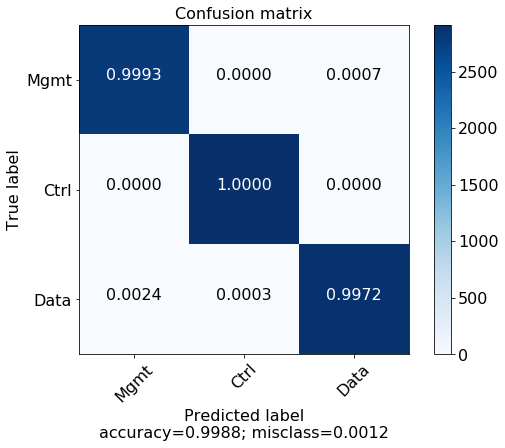

In [40]:
plot_confusion_matrix_mc(Y_true, Y_pred, ["Mgmt","Ctrl","Data"], "conf_matrix_test.pdf")

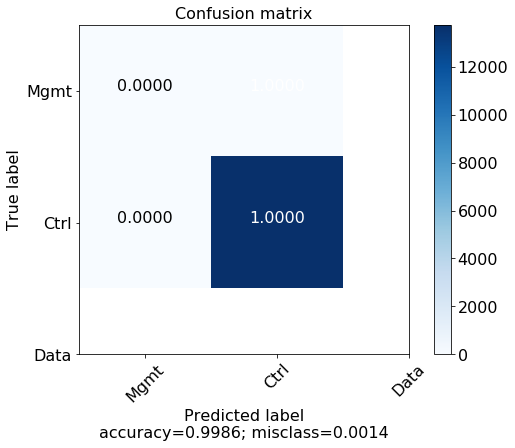

In [41]:
plot_confusion_matrix_mc(Y_pred_qos, Y_true_qos, ["Mgmt","Ctrl","Data"], "conf_matrix_qos.pdf")

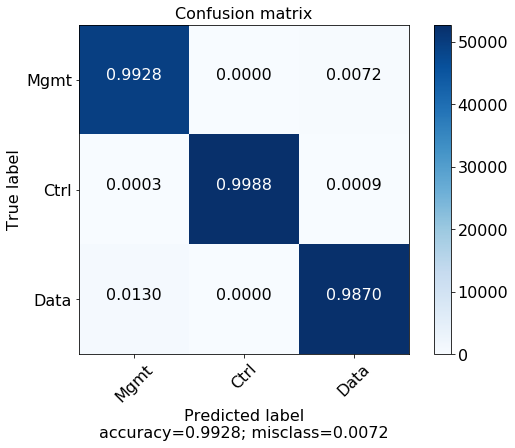

In [42]:
plot_confusion_matrix_mc(Y_pred_test2, Y_true_test2, ["Mgmt","Ctrl","Data"], "conf_matrix_test2.pdf")